<img align=center src="https://rhyme.com/assets/img/logo-dark.png"></img>
<h2 align=center> Named Entity Recognition (NER) using LSTMs with Keras</h2>

### Task 1: Project Overview and Import Modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.1.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Task 2: Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [4]:
data = pd.read_csv('ner_dataset.csv', encoding='latin')
data = data.fillna(method='ffill')
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [8]:
print('Unique words in corpus:', data['Word'].nunique())
print('Unique tags in corpus:', data['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


In [9]:
words = list(set(data['Word'].values))
words.append('ENDPAD')
num_words = len(words)

In [10]:
num_words

35179

In [11]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)

In [23]:
tags

['I-nat',
 'I-per',
 'O',
 'I-gpe',
 'I-geo',
 'B-art',
 'I-tim',
 'B-tim',
 'B-nat',
 'I-org',
 'B-eve',
 'B-per',
 'I-art',
 'I-eve',
 'B-gpe',
 'B-org',
 'B-geo']

In [12]:
num_words, num_tags

(35179, 17)

### Task 3: Retrieve Sentences and Corresponsing Tags

In [15]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        agg_function = lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                              s['POS'].values.tolist(),
                                                              s['Tag'].values.tolist())]
        
        self.grouped = self.data.groupby('Sentence #').apply(agg_function)
        self.sentences = [s for s in self.grouped]

In [16]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [19]:
sentences[1]

[('Iranian', 'JJ', 'B-gpe'),
 ('officials', 'NNS', 'O'),
 ('say', 'VBP', 'O'),
 ('they', 'PRP', 'O'),
 ('expect', 'VBP', 'O'),
 ('to', 'TO', 'O'),
 ('get', 'VB', 'O'),
 ('access', 'NN', 'O'),
 ('to', 'TO', 'O'),
 ('sealed', 'JJ', 'O'),
 ('sensitive', 'JJ', 'O'),
 ('parts', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('the', 'DT', 'O'),
 ('plant', 'NN', 'O'),
 ('Wednesday', 'NNP', 'B-tim'),
 (',', ',', 'O'),
 ('after', 'IN', 'O'),
 ('an', 'DT', 'O'),
 ('IAEA', 'NNP', 'B-org'),
 ('surveillance', 'NN', 'O'),
 ('system', 'NN', 'O'),
 ('begins', 'VBZ', 'O'),
 ('functioning', 'VBG', 'O'),
 ('.', '.', 'O')]

### Task 4: Define Mappings between Sentences and Tags

In [20]:
word2idx = {w: i+1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [21]:
word2idx

{'navies': 1,
 'militaristic': 2,
 'Leroy': 3,
 'Sharon': 4,
 'Datta': 5,
 'ignite': 6,
 'setting': 7,
 'deploy': 8,
 'Besir': 9,
 "I'd": 10,
 'profitability': 11,
 'denying': 12,
 're-started': 13,
 'underreporting': 14,
 '2023': 15,
 'Eugenio': 16,
 'real': 17,
 'knowing': 18,
 'Schultz': 19,
 'Candlemas': 20,
 'Slovak': 21,
 'Somali-born': 22,
 'juror': 23,
 'intently': 24,
 'Gaston': 25,
 'pharmaceutical': 26,
 'mourn': 27,
 'bases': 28,
 'wide-body': 29,
 '12-kilometer-high': 30,
 'originally': 31,
 'structur': 32,
 'Protest': 33,
 'Mao': 34,
 'tribunal': 35,
 'Argentinean': 36,
 'stimulating': 37,
 'conglomerate': 38,
 'Ah': 39,
 'placard': 40,
 'anti-Taleban': 41,
 'went': 42,
 'guaranteeing': 43,
 'rear': 44,
 'Akhmad': 45,
 'game-bag': 46,
 '1,675': 47,
 "Shi'te": 48,
 'communist-era': 49,
 'from': 50,
 'Oil-rich': 51,
 'ablaze': 52,
 'contained': 53,
 'supporting-actor': 54,
 'inefficient': 55,
 'Ratner': 56,
 'widows': 57,
 'quail': 58,
 'tidings': 59,
 'Hallums': 60,
 'payb

In [22]:
tag2idx

{'I-nat': 0,
 'I-per': 1,
 'O': 2,
 'I-gpe': 3,
 'I-geo': 4,
 'B-art': 5,
 'I-tim': 6,
 'B-tim': 7,
 'B-nat': 8,
 'I-org': 9,
 'B-eve': 10,
 'B-per': 11,
 'I-art': 12,
 'I-eve': 13,
 'B-gpe': 14,
 'B-org': 15,
 'B-geo': 16}

### Task 5: Padding Input Sentences and Creating Train/Test Splits

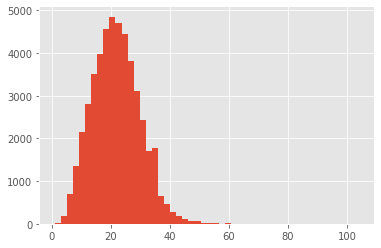

In [24]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [26]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X  = pad_sequences(maxlen=max_len, sequences=X, padding='post', value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences = y, padding = 'post', value=tag2idx['O'])

y = [to_categorical(i, num_classes=num_tags) for i in y]

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=1)

### Task 6: Build and Compile a Bidirectional LSTM Model

In [29]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [34]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.compile(optimizer='adam',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

### Task 7: Train the Model

In [36]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

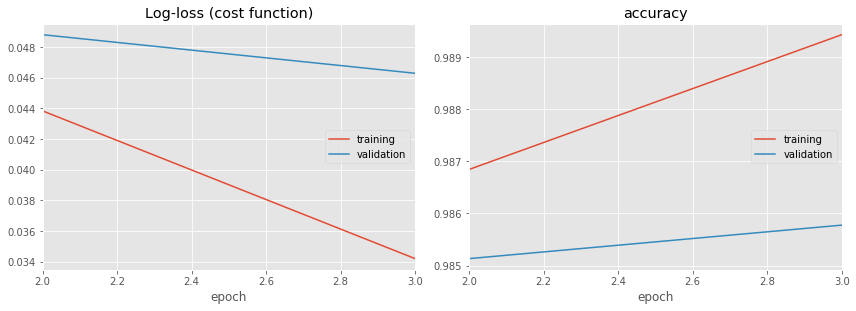

Log-loss (cost function):
training   (min:    0.034, max:    0.079, cur:    0.034)
validation (min:    0.046, max:    0.055, cur:    0.046)

accuracy:
training   (min:    0.978, max:    0.989, cur:    0.989)
validation (min:    0.983, max:    0.986, cur:    0.986)
34530/34530 [==============================] - 192s 6ms/sample - loss: 0.0342 - accuracy: 0.9894 - val_loss: 0.0463 - val_accuracy: 0.9858


In [40]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=2,
                               verbose=0,
                               mode='max',
                             restore_best_weights=False)

callbacks = [PlotLossesCallback(), early_stopping]

history = model.fit(
    X_train, np.array(y_train),
    validation_split=0.2,
    batch_size=32,
    epochs=3,
    verbose=1,
    callbacks=callbacks
)

### Task 8: Evaluate Named Entity Recognition Model

In [41]:
model.evaluate(X_test, np.array(y_test))

4796/4796 [==============================] - 6s 1ms/sample - loss: 0.0485 - accuracy: 0.9854


[0.04849056483831279, 0.98542535]

In [52]:
np.array(X_test[8]).shape

(50,)

In [61]:
i = np.random.randint(0, X_test.shape[0])
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
y_true = np.argmax(np.array(y_test), axis=-1)[i]
                  
print("{:15}{:5}\t{}\n".format('Word', 'True', 'Pred'))
print("-"*30)
for w , true, pred in zip(X_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true],tags[pred]))

Word           True 	Pred

------------------------------
Shaima         B-per	O
Rezayee        I-per	B-per
had            O	O
presented      O	O
a              O	O
music          O	O
program        O	O
on             O	O
the            O	O
privately-run  O	O
television     O	O
channel        O	O
Tolo           B-org	B-org
TV             I-org	I-org
,              O	O
and            O	O
was            O	O
shot           O	O
in             O	O
the            O	O
head           O	O
in             O	O
the            B-geo	O
Kabul          I-geo	B-geo
neighborhood   O	O
of             O	O
Char           B-org	B-geo
Qala           I-org	I-org
on             O	O
Wednesday      B-tim	B-tim
.              O	O
104.6          O	O
104.6          O	O
104.6          O	O
104.6          O	O
104.6          O	O
104.6          O	O
104.6          O	O
104.6          O	O
104.6          O	O
104.6          O	O
104.6          O	O
104.6          O	O
104.6          O	O
104.6          O	O
104.6          O	O
104.